In [1]:
!pip install -q numerapi pandas pyarrow matplotlib lightgbm scikit-learn cloudpickle scipy==1.10.1

# Inline plots
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 14.5 MB/s eta 0:00:00


In [2]:
# Initialize NumerAPI - the official Python API client for Numerai
from numerapi import NumerAPI
napi = NumerAPI()

# list the datasets and available versions
all_datasets = napi.list_datasets()
dataset_versions = list(set(d.split('/')[0] for d in all_datasets))
print("Available versions:\n", dataset_versions)

# Set data version to one of the latest datasets
DATA_VERSION = "v4.3"

# Print all files available for download for our version
current_version_files = [f for f in all_datasets if f.startswith(DATA_VERSION)]
print("availbable", DATA_VERSION, "files:\n", current_version_files)

Available versions:
 ['v4.2', 'v4.3', 'v4.1', 'v4']
availbable v4.3 files:
 ['v4.3/features.json', 'v4.3/live_benchmark_models.parquet', 'v4.3/live_example_preds.csv', 'v4.3/live_example_preds.parquet', 'v4.3/live_int8.parquet', 'v4.3/meta_model.parquet', 'v4.3/train_benchmark_models.parquet', 'v4.3/train_int8.parquet', 'v4.3/validation_benchmark_models.parquet', 'v4.3/validation_example_preds.csv', 'v4.3/validation_example_preds.parquet', 'v4.3/validation_int8.parquet']


In [3]:
import json

# download the feature metadata file
napi.download_dataset(f"{DATA_VERSION}/features.json");

# read the metadata and display
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
for metadata in feature_metadata:
  print(metadata, len(feature_metadata[metadata]))

v4.3/features.json: 1.12MB [00:00, 14.9MB/s]                   

feature_stats 2376
feature_sets 17
targets 41


In [4]:
feature_sets = feature_metadata["feature_sets"]
for feature_set in ["small", "medium", "all"]:
  print(feature_set, len(feature_sets[feature_set]))

small 42
medium 705
all 2376


In [5]:
import pandas as pd

# Define our feature set
feature_set = feature_sets["small"]

# Download the training data - this will take a few minutes
napi.download_dataset(f"{DATA_VERSION}/train_int8.parquet");

# Load only the "medium" feature set to
# Use the "all" feature set to use all features
train = pd.read_parquet(
    f"{DATA_VERSION}/train_int8.parquet",
    columns=["era", "target"] + feature_set
)

# Downsample to every 4th era to reduce memory usage and speedup model training (suggested for Colab free tier)
# Comment out the line below to use all the data
train = train[train["era"].isin(train["era"].unique()[::4])]

v4.3/train_int8.parquet: 2.09GB [01:00, 34.6MB/s]                            


In [6]:
df = pd.read_parquet(
    f"{DATA_VERSION}/train_int8.parquet",
    columns=["era", "target"] + feature_set
)

# Downsample to every 4th era to reduce memory usage and speedup model training (suggested for Colab free tier)
# Comment out the line below to use all the data
df = df[df["era"].isin(df["era"].unique()[::4])]

In [7]:
X = df.drop(['era', 'target'], axis=1)
y = df['target']

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn import datasets, linear_model, preprocessing
from sklearn.metrics import mean_squared_error

In [10]:
regr = linear_model.LinearRegression()

In [11]:
regr.fit(X_train,y_train)


LinearRegression()

In [12]:
y_tr_pred = regr.predict(X_train)
y_tr_val = regr.predict(X_val)

In [13]:
import numpy as np
np.array(y_tr_pred)

array([0.50298025, 0.50339645, 0.50815226, ..., 0.51350179, 0.49125878,
       0.50871814])

In [14]:
train_error = mean_squared_error(y_train,y_tr_pred)
validation_error = mean_squared_error(y_val, y_tr_val)
print(train_error)
print(validation_error)

0.04972580916155939
0.049640978525291014


PCA Transformation + Degree 2

In [15]:
from sklearn.decomposition import PCA



In [16]:
components = [5,10,15,20,25,30,35,40]
from sklearn.preprocessing import PolynomialFeatures



In [17]:
train_pca = []
val_pca = []

In [19]:
for component in components:
  pca = PCA(n_components=component)
  X_train_pca = pca.fit_transform(X_train)
  X_val_pca = pca.fit_transform(X_val)
  poly = PolynomialFeatures(degree=2, include_bias=False)
  X_train_poly = poly.fit_transform(X_train_pca)
  X_val_poly = poly.transform(X_val_pca)
  model = linear_model.LinearRegression()
  model.fit(X_train_poly, y_train)
  y_train_pred = model.predict(X_train_poly)
  y_val_pred = model.predict(X_val_poly)
  train_error = mean_squared_error(y_train, y_train_pred)
  val_error = mean_squared_error(y_val, y_val_pred)
  print(component, train_error)
  print(component,val_error)
  train_pca.append(train_error)
  val_pca.append(val_error)

5 0.04977373889509094
5 0.049737563356181555
10 0.049751385120544354
10 0.04972928690614081
15 0.04973115571988099
15 0.04980487176646248
20 0.04970237677866305
20 0.0497934342097438
25 0.04967748447322429
25 0.04984756772180439
30 0.04965389922014246
30 0.04986679489817471
35 0.049633826300132605
35 0.04987618283838515
40 0.04959410515020154
40 0.04989331625028718


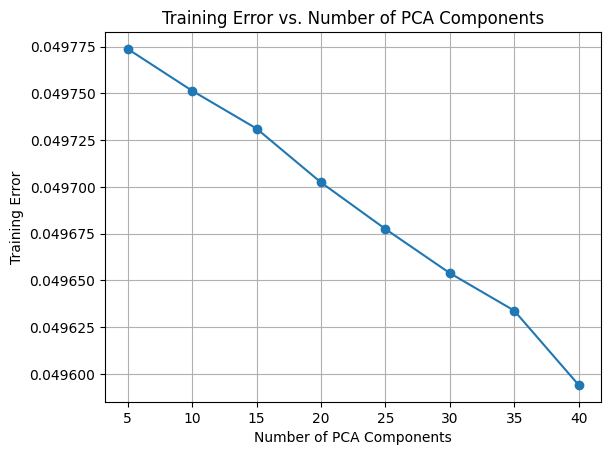

In [20]:
import matplotlib.pyplot as plt
plt.plot(components, train_pca, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Training Error')
plt.title('Training Error vs. Number of PCA Components')
plt.grid(True)
plt.show()

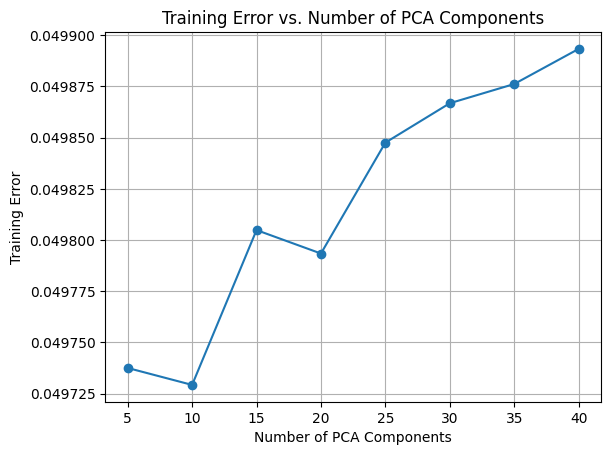

In [21]:
import matplotlib.pyplot as plt
plt.plot(components, val_pca, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Training Error')
plt.title('Training Error vs. Number of PCA Components')
plt.grid(True)
plt.show()

In [22]:
train_ = []
val_ = []

In [23]:
components_ = [2,4,6,8,10,12,14,15]

In [24]:
for component in components_:
  pca = PCA(n_components=component)
  X_train_pca = pca.fit_transform(X_train)
  X_val_pca = pca.fit_transform(X_val)
  poly = PolynomialFeatures(degree=3, include_bias=False)
  X_train_poly = poly.fit_transform(X_train_pca)
  X_val_poly = poly.transform(X_val_pca)
  model = linear_model.LinearRegression()
  model.fit(X_train_poly, y_train)
  y_train_pred = model.predict(X_train_poly)
  y_val_pred = model.predict(X_val_poly)
  train_error = mean_squared_error(y_train, y_train_pred)
  val_error = mean_squared_error(y_val, y_val_pred)
  print(component, train_error)
  print(component,val_error)
  train_.append(train_error)
  val_.append(val_error)

2 0.04978463225971701
2 0.04971285272512784
4 0.04976532223624407
4 0.04975869538404466
6 0.04975763079818923
6 0.0497728078631195
8 0.04973875978159524
8 0.04979113836493255
10 0.049714266769645236
10 0.04983265852354451
12 0.04969259926145847
12 0.04979166178203585
14 0.04965702689593208
14 0.04988411434249865
15 0.04963844317860748
15 0.04990921137373705


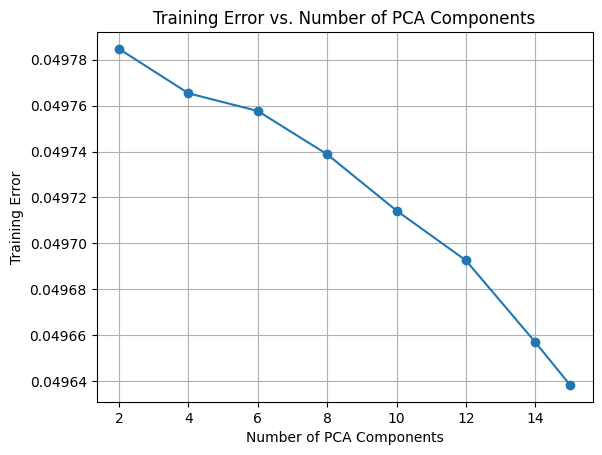

In [25]:
plt.plot(components_, train_, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Training Error')
plt.title('Training Error vs. Number of PCA Components')
plt.grid(True)
plt.show()

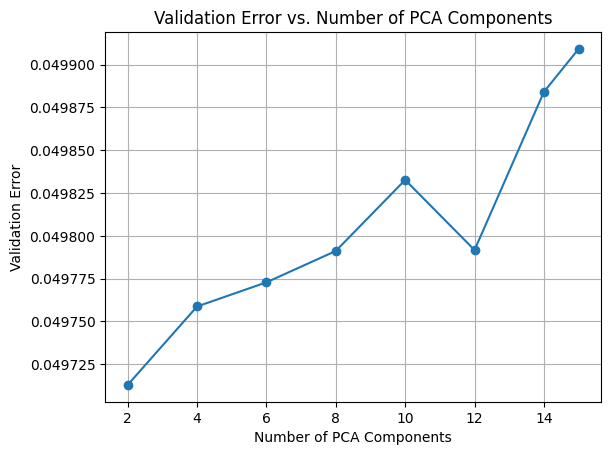

In [26]:
plt.plot(components_, val_, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Validation Error')
plt.title('Validation Error vs. Number of PCA Components')
plt.grid(True)
plt.show()

In [ ]:
L1 Regularization

In [27]:
from sklearn.linear_model import Lasso

In [28]:
alpha_vals = [0.001, 0.01, 0.1 , 1, 10, 100]
lasso_train = []
lasso_val = []

In [29]:
for alpha in alpha_vals:
        lasso = Lasso(alpha=alpha, max_iter= 100)
        lasso.fit(X_train, y_train)
        train_error = mean_squared_error(y_train, lasso.predict(X_train))
        val_error = mean_squared_error(y_val, lasso.predict(X_val))
        lasso_train.append(train_error)
        lasso_val.append(val_error)
        print(alpha, train_error, val_error)

0.001 0.04974810554272731 0.0496533304138484
0.01 0.049797617003031806 0.049694701081871025
0.1 0.049797617003031806 0.049694701081871025
1 0.049797617003031806 0.049694701081871025
10 0.049797617003031806 0.049694701081871025
100 0.049797617003031806 0.049694701081871025


In [ ]:
lasso_train
lasso_val

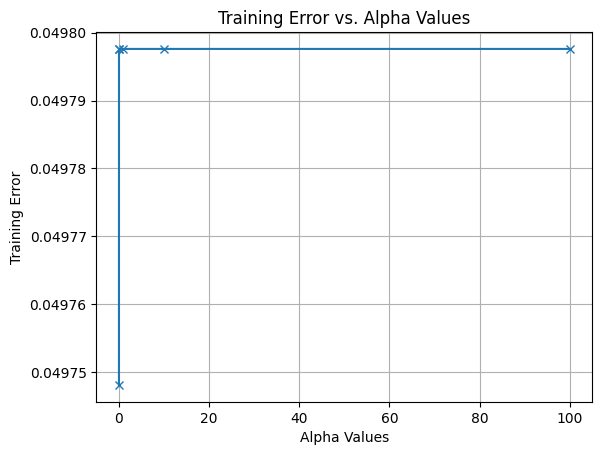

In [30]:

plt.plot(alpha_vals, lasso_train, marker='x')
plt.xlabel('Alpha Values')
plt.ylabel('Training Error')
plt.title('Training Error vs. Alpha Values')
plt.grid(True)
plt.show()

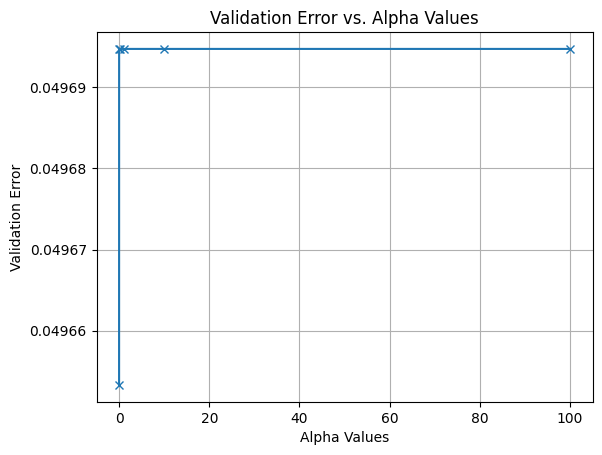

In [31]:
plt.plot(alpha_vals, lasso_val, marker='x')
plt.xlabel('Alpha Values')
plt.ylabel('Validation Error')
plt.title('Validation Error vs. Alpha Values')
plt.grid(True)
plt.show()

In [ ]:
L2 Regularization

In [32]:
from sklearn.linear_model import Ridge
ridge_train = []
ridge_val= []

In [33]:
for alpha in alpha_vals:
        ridge = Ridge(alpha=alpha, max_iter=100)
        ridge.fit(X_train, y_train)
        train_error = mean_squared_error(y_train, ridge.predict(X_train))
        val_error = mean_squared_error(y_val, ridge.predict(X_val))
        ridge_train.append(train_error)
        ridge_val.append(val_error)
        print(alpha, train_error, val_error)

0.001 0.049725809161559394 0.049640978525256216
0.01 0.049725809161559394 0.04964097852494312
0.1 0.0497258091615594 0.049640978521812026
1 0.04972580916155962 0.049640978490501454
10 0.04972580916158217 0.04964097817742656
100 0.04972580916383726 0.04964097504974187


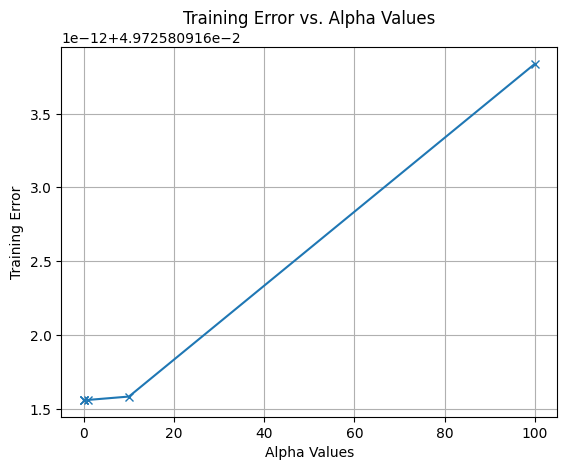

In [34]:

plt.plot(alpha_vals, ridge_train, marker='x')
plt.xlabel('Alpha Values')
plt.ylabel('Training Error')
plt.title('Training Error vs. Alpha Values')
plt.grid(True)
plt.show()

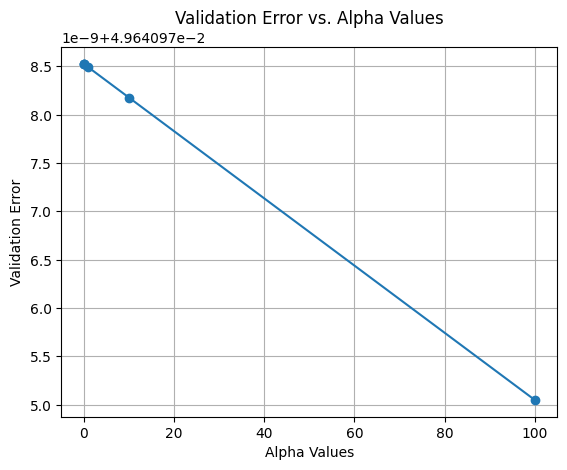

In [35]:
plt.plot(alpha_vals, ridge_val, marker='o')
plt.xlabel('Alpha Values')
plt.ylabel('Validation Error')
plt.title('Validation Error vs. Alpha Values')
plt.grid(True)
plt.show()